# 가설 검정

## `두 집단 평균 비교 -- 독립 표본 t-test(independent sample t-test)`
- 목적: 독립된 두 표본집단의 평균 차이에 대한 가설 검정
- 예제: K 모바일 대리점 내부 인테리어 종류에 따라 고객 선호도에 대한 차이가 통계적으로 유의미한지 확인해본다.
    - (note: 마케팅 분야에서 A/B테스트 시 두 집단의 평균에 차이가 있는지 검정할 때 주로 사용된다.)

- 귀무가설(Ho): 내부 인테리어 종류에 따라 고객 선호도에 차이가 없다.
- 대립가설(H1): 내부 인테리어 종류에 따라 고객 선호도에 차이가 있다. 

## 0. 라이브러리 및 데이터 로딩

In [1]:
# 필요 라이브러리 로딩
import numpy as np
import pandas as pd

from scipy import stats # scipy: 수학, 과학, 공학에 특화된 라이브러리

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest, levene

# 설정
np.random.seed(42)

# 데이터 생성
def generate_data(mean, std, size):
    return np.random.normal(loc=mean, scale=std, size=size)

# Classic 그룹: 중앙값 46, IQR [26, 68]
classic_mean = 46
classic_std = (68 - 26) / 2  # 대략적인 표준편차

# Modern 그룹: 중앙값 60, IQR [41, 73]
modern_mean = 60
modern_std = (73 - 41) / 2  # 대략적인 표준편차

# 데이터프레임 생성
n_per_group = 15
classic_data = generate_data(classic_mean, classic_std, n_per_group)
modern_data = generate_data(modern_mean, modern_std, n_per_group)

# 데이터프레임
df = pd.DataFrame({
    'preference': np.concatenate([classic_data, modern_data]),
    'interior': ['classic'] * n_per_group + ['modern'] * n_per_group
})

### 0-1. boxplot

Text(0.5, 1.0, 'Box Plot of Preference of Interior')

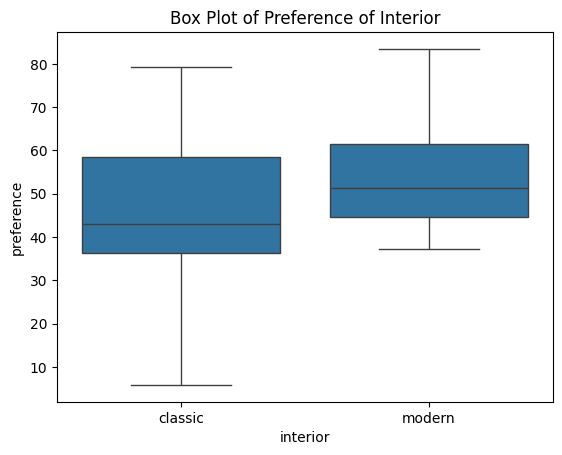

In [3]:
# sns.boxplot(x=df['interior'], y=df['preference'])
# plt.title('Box Plot of Preference of interior')
# plt.show()
p = sns.boxplot(x=df['interior'], y=df['preference'])
p.set_title('Box Plot of Preference of Interior')

## Assumption 1: 독립성
> 독립변수 그룹은 서로 독립적
- 두 개의 집단을 구성하는 구성원이나 구성들이 서로 관계가 없음을 의미. 즉, 아무런 관계가 없어야 함
- 이미 두 개의 독립된 집단이기에 따로 검정은 필요 없다. 

## Assumption 2: 정규성 확인
> Shapiro-Wilk 검정을 통해 정규성을 확인합니다. (귀무가설과 대립가설은 다음과 같음)
- Ho: 각 독립 표본이 정규성을 만족한다.
- H1: 각 독립 표본이 정규성을 만족하지 않는다. 

- 검정통계량에 대한 유의확률과 유의수준을 통해 분석을 했을 때, 귀무가설을 기각하게 된다면 정규성을 만족하지 않는 것이고,
- 귀무가설을 기각하지 않는다면 정규성을 만족한다고 볼 수 있다. 

In [4]:
df[df['interior'] == 'classic'].head()
df.loc[df['interior'] == 'modern', 'interior'].value_counts()

interior
modern    15
Name: count, dtype: int64

In [5]:
# 각 그룹의 선호도 
classic_pref = df.loc[df['interior'] == 'classic', 'preference']
# classic_pref
modern_pref = df.loc[df['interior'] == 'modern', 'preference']
print(modern_pref)

15    51.003400
16    43.794702
17    65.027957
18    45.471615
19    37.403141
20    83.450380
21    56.387579
22    61.080451
23    37.204029
24    51.289876
25    61.774761
26    41.584103
27    66.011168
28    50.389781
29    55.332900
Name: preference, dtype: float64


In [6]:
modern_pref.size # 몇 개의 데이터가 있는가?

15

In [7]:
# 정규성을 충족하는지 확인
print('classic 인테리어 선호도 정규성 shapiro test : ', stats.shapiro(classic_pref))
print('modern 인테리어 선호도 정규성 shapiro test : ', stats.shapiro(modern_pref))

classic 인테리어 선호도 정규성 shapiro test :  ShapiroResult(statistic=0.9428404514723788, pvalue=0.41943322393776156)
modern 인테리어 선호도 정규성 shapiro test :  ShapiroResult(statistic=0.9474447844818342, pvalue=0.4851442128002757)


- 정규성 검정 결과, 두 집단 모두 정규성 가정을 만족
- statistic은 검정통계량을 의미하고, p-value는 유의확률을 의미한다. (pvalue가 0.5보다 크므로 귀무가설 채택)

## Assumption 3: 등분산성 확인(두 집단이 동일한 분산을 가지는가?)
> F 검정으로 확인
- Ho: 두 독립 표본의 분산은 동일하다.
- H1: 두 독립 표본의 분산은 동일하지 않다.

In [8]:
# numpy의 variance는 population variance를 구함. sample variance를 구하라
f = np.var(classic_pref, ddof=1) / np.var(modern_pref, ddof=1) 
classic_size = classic_pref.size - 1
modern_size = modern_pref.size - 1

p_value = 1 - stats.f.cdf(f, classic_size, modern_size)

print('F statistic : {}'.format(np.round(f, 4)))
# print('p value : {}'.format(np.round(p_value, 4)))
print('p value : {:.3f}'.format(p_value, 4))

F statistic : 2.8137
p value : 0.031


In [9]:
def f_test(g1, g2):
    f = np.var(g1, ddof=1) / np.var(g2, ddof=1) # f 통계검정량
    num = g1.size - 1 # 분자
    denom = g2.size - 1 # 분모

    p_value = 1 - stats.f.cdf(f, num, denom) # f 검정통계량에 대한 p-value

    return f, p_value

In [10]:
print('F 검정통계량 : {:.4f}'.format(f_test(classic_pref, modern_pref)[0]))
print('p value : {:.3f}'.format(f_test(classic_pref, modern_pref)[1]))

F 검정통계량 : 2.8137
p value : 0.031


## 1. 독립표본 t 검정

In [11]:
# 평균 확인
print(np.mean(classic_pref))
print(np.mean(modern_pref))

46.217319011000065
53.81372294343342


In [16]:
# stats.ttest_ind 독립표본 t검정 함수
result = stats.ttest_ind(classic_pref, modern_pref, equal_var=False) 
# 동일분산을 갖는가? false equal_var=False

In [17]:
result

TtestResult(statistic=-1.210445831367359, pvalue=0.23848835105149702, df=22.83533221520818)

In [13]:
print('classic 인테리어 평균 선호도 : {}'.format(np.mean(classic_pref)))
print('modern 인테리어 평균 선호도 : {}'.format(np.round(np.mean(modern_pref), 4)))
print('독립표본 t 검정통계량 : {}'.format(result[0].astype(str)[:6]))
print('p - value : {}'.format(result[1].astype(str)[:5]))

classic 인테리어 평균 선호도 : 46.217319011000065
modern 인테리어 평균 선호도 : 53.8137
독립표본 t 검정통계량 : -1.210
p - value : 0.238
